<a href="https://colab.research.google.com/github/ravindu556/cm2604-telco-churn/blob/main/telco_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

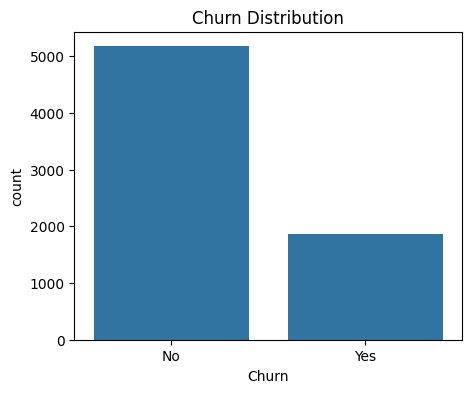

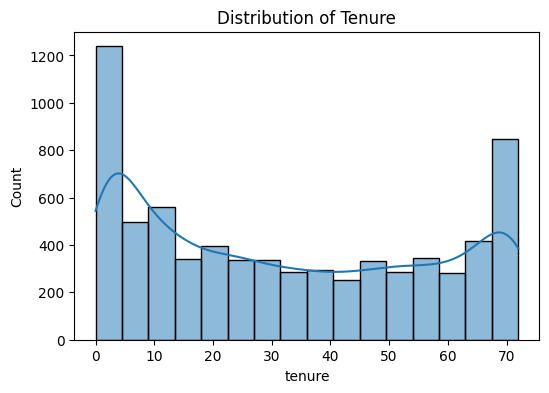

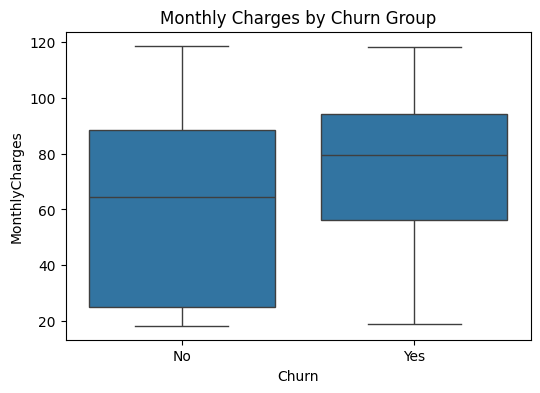

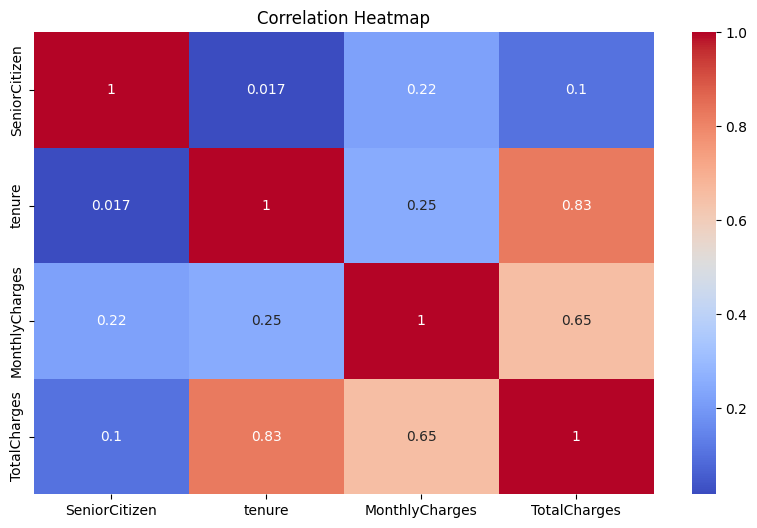

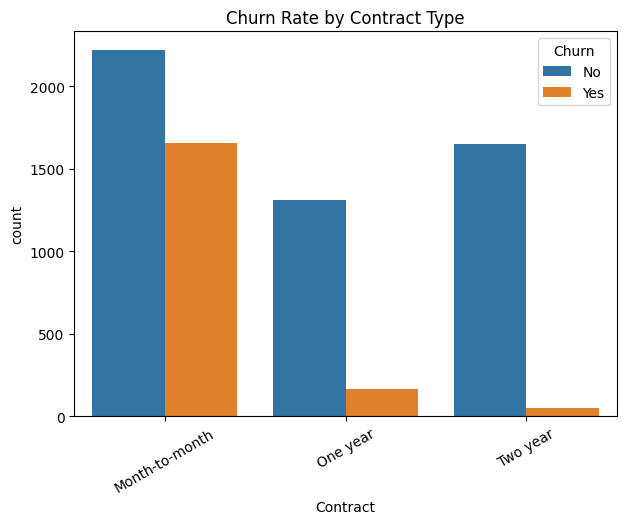

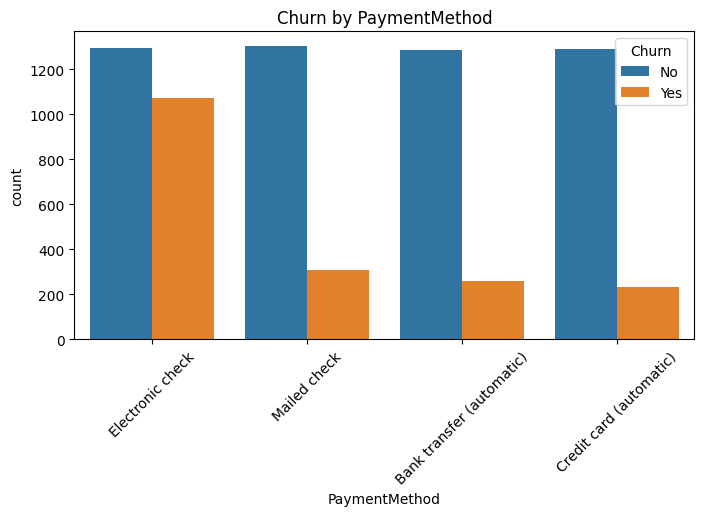

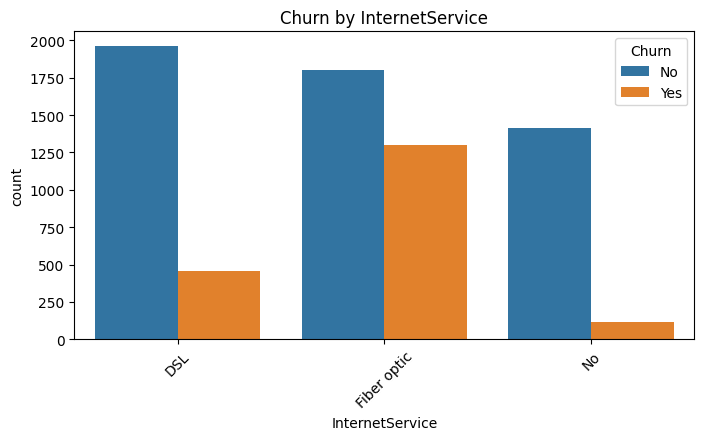

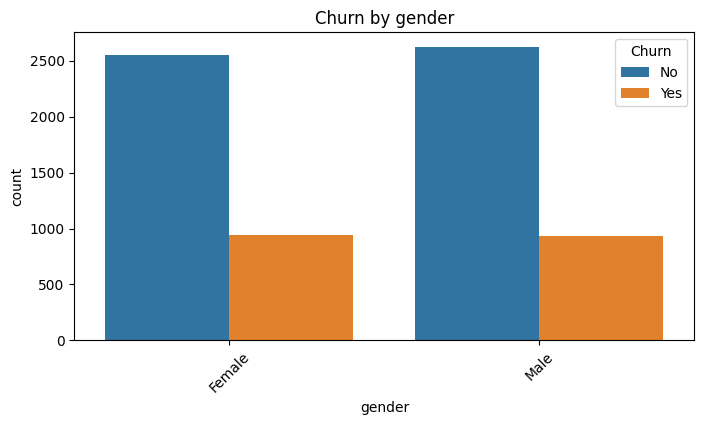

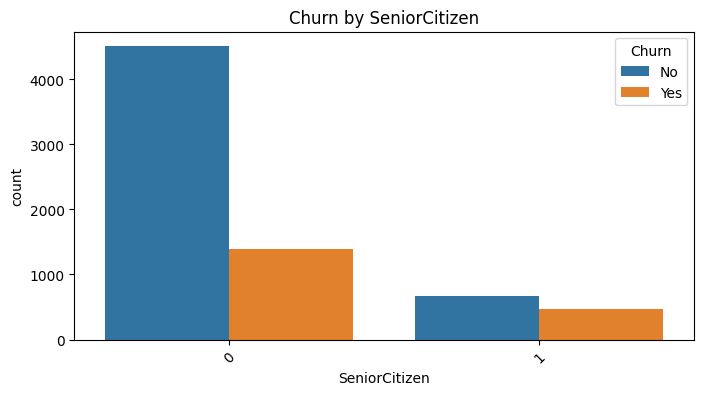

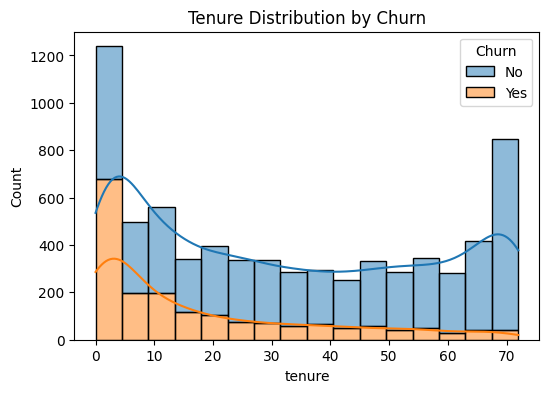

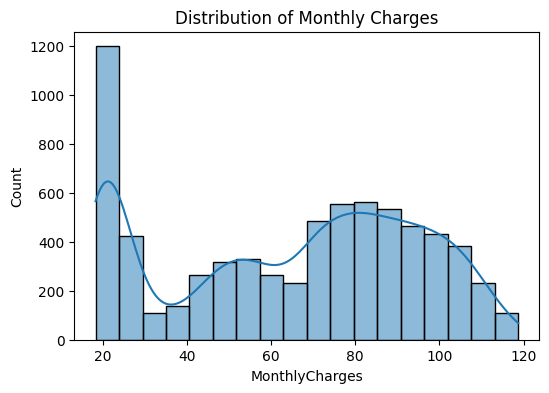

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import random
import os

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


pd.set_option('display.max_columns', None)


pd.set_option('display.max_columns', None)

# Load the Telco Customer Churn dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


# --- Exploratory Data Analysis (EDA) ---

# Print dataset shape (rows, columns)
print("Dataset shape:", df.shape)
df.info()

# Check missing values for each column
print("Missing values per column:")
print(df.isnull().sum())

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print("\nMissing values after converting TotalCharges:")
print(df.isnull().sum())
#df.isnull().sum()

print("\nNumber of duplicate rows:", df.duplicated().sum())

# Summary statistics for numerical and categorical columns
df.describe(include="all")

# Check percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
print("Missing values percentage:\n", missing_percent)

#  Check target variable percentages(class imbalance check)
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)


# --- VISUALIZATIONS ---

plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['tenure'], kde=True)
plt.title("Distribution of Tenure")
plt.show()


plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn Group")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.drop('customerID', axis=1).corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn Rate by Contract Type")
plt.xticks(rotation=30)
plt.show()


#  Churn distribution across important categorical features
categorical_cols = ['PaymentMethod', 'InternetService', 'gender', 'SeniorCitizen']
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.show()

#  Tenure distribution split by churn (who leaves earlier?)
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, multiple='stack')
plt.title("Tenure Distribution by Churn")
plt.show()

#  Monthly charges distribution
plt.figure(figsize=(6,4))
sns.histplot(df['MonthlyCharges'], kde=True)
plt.title("Distribution of Monthly Charges")
plt.show()





Number of duplicate rows before: 0
Number of duplicate rows after: 0


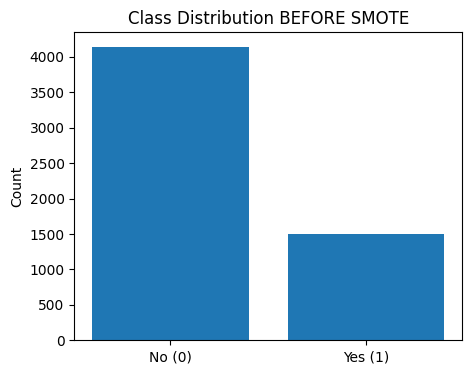


🔵 Class Distribution BEFORE SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

Percentage:
Churn
0    73.46
1    26.54
Name: count, dtype: float64


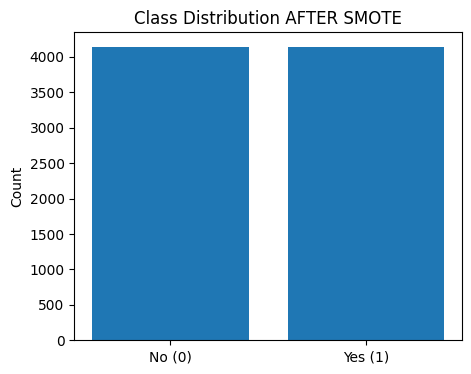


🟢 Class Distribution AFTER SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64

Percentage:
Churn
0    50.0
1    50.0
Name: count, dtype: float64
Scaling complete!


In [5]:

# ------Data preprocessing------

#  Handle the missing TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# Check number of duplicate rows
print("Number of duplicate rows before:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Number of duplicate rows after:", df.duplicated().sum())


# Convert target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID
df = df.drop('customerID', axis=1)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Split data
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  before BALANCING BAR CHART
plt.figure(figsize=(5,4))
plt.bar(['No (0)', 'Yes (1)'], y_train.value_counts().sort_index())
plt.title("Class Distribution BEFORE SMOTE")
plt.ylabel("Count")
plt.show()

print("\n🔵 Class Distribution BEFORE SMOTE:")
print(y_train.value_counts())
print("\nPercentage:")
print(round((y_train.value_counts() / len(y_train)) * 100, 2))


#  APPLY SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


#  AFTER BALANCING BAR CHART
plt.figure(figsize=(5,4))
plt.bar(['No (0)', 'Yes (1)'], y_train_bal.value_counts().sort_index())
plt.title("Class Distribution AFTER SMOTE")
plt.ylabel("Count")
plt.show()

print("\n🟢 Class Distribution AFTER SMOTE:")
print(y_train_bal.value_counts())
print("\nPercentage:")
print(round((y_train_bal.value_counts() / len(y_train_bal)) * 100, 2))

# STANDARD SCALING
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

print("Scaling complete!")


Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4}

===== Decision Tree Evaluation =====
Accuracy : 0.7402413058907026
Precision: 0.5076923076923077
Recall   : 0.7058823529411765
F1 Score : 0.5906040268456376

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.51      0.71      0.59       374

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409



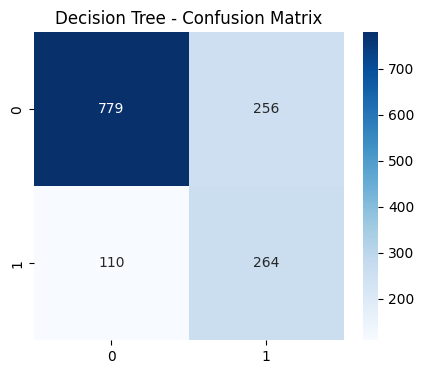

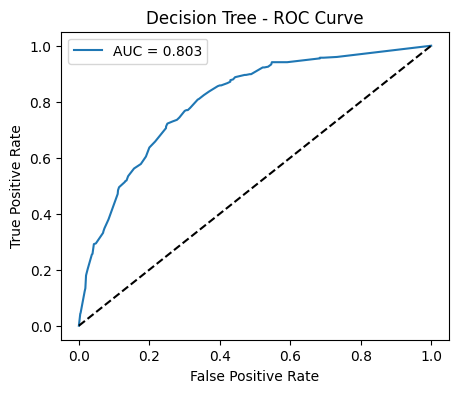

/tmp/ipython-input-4100699357.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), palette="viridis")


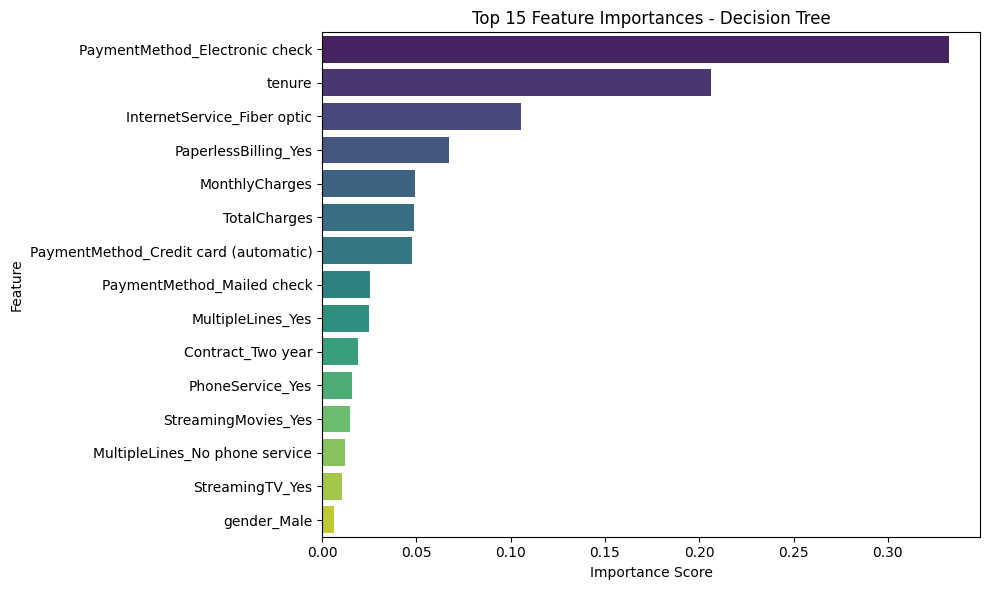

Training: neurons=64, dropout=0.2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training: neurons=64, dropout=0.3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training: neurons=128, dropout=0.2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training: neurons=128, dropout=0.3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   neurons  dropout  f1_score
3      128      0.3  0.606827
1       64      0.3  0.600780
0       64      0.2  0.590850
2      128      0.2  0.585987

Best parameters: neurons     128.000000
dropout       0.300000
f1_score      0.606827
Name: 3, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

===== Tuned Neural Network Evaluation =====
Accuracy : 0.7764371894960965
Precision: 0.5739348370927319
Recall   : 0.6122994652406417
F1 Score : 0.592496765847348

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.57      0.61      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



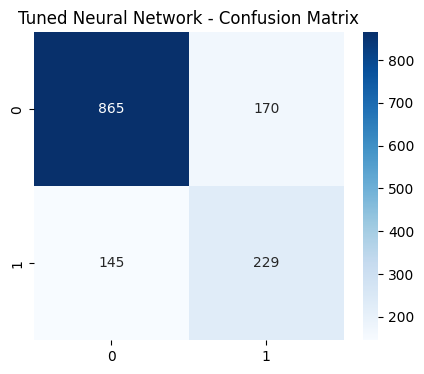

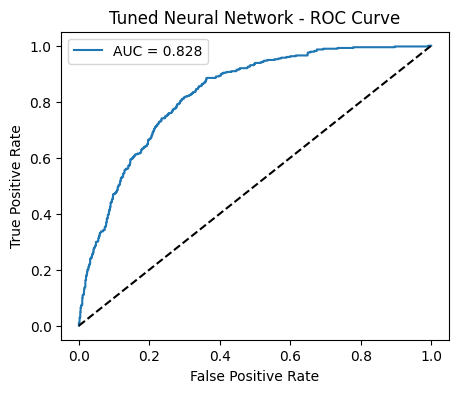


FINAL MODEL COMPARISON (ALL MODELS)
          Accuracy  Precision   Recall  F1 Score
Tuned DT  0.740241   0.507692 0.705882  0.590604
Tuned NN  0.776437   0.573935 0.612299  0.592497


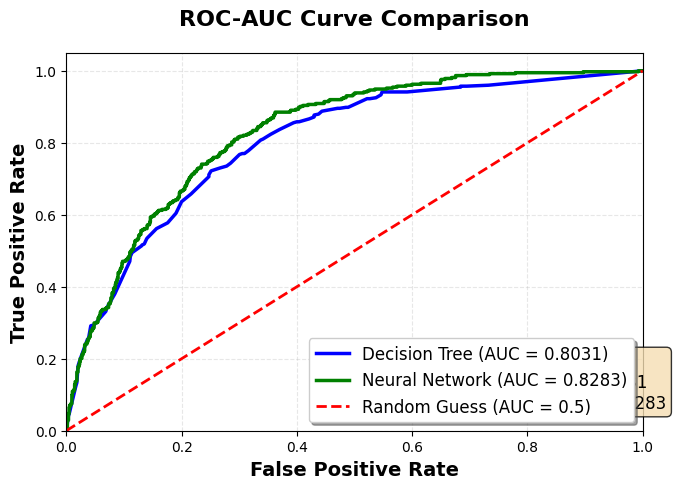


ROC-AUC COMPARISON RESULTS

Decision Tree ROC-AUC: 0.8031
Neural Network ROC-AUC: 0.8283


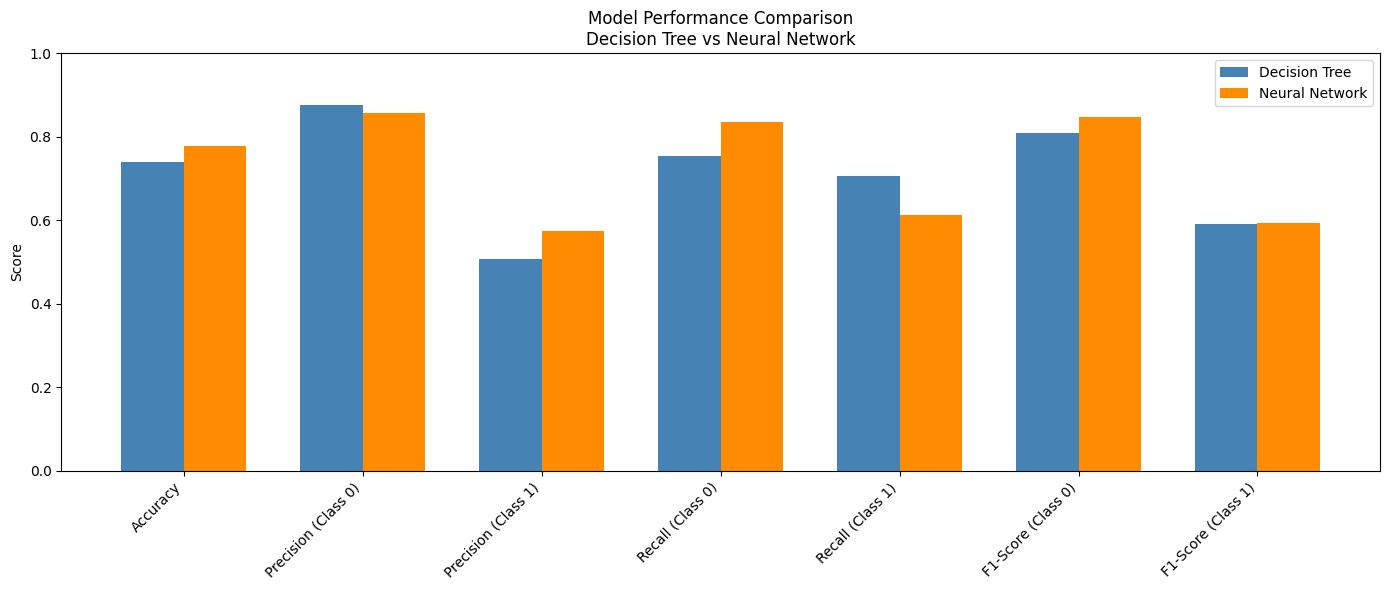

In [7]:

#  ----- Model Implementation------

def evaluate_model(model_name, y_true, y_pred, y_probs=None):
    print(f"\n===== {model_name} Evaluation =====")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(model_name + " - Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_probs is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc = roc_auc_score(y_true, y_probs)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0,1],[0,1],"k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(model_name + " - ROC Curve")
        plt.legend()
        plt.show()


#  ------DECISION TREE CLASSIFIER------
param_grid = {
    "max_depth": [4, 6, 8, None],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

dt = DecisionTreeClassifier(random_state=42)

grid = GridSearchCV(dt, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid.fit(X_train_bal, y_train_bal)

print("Best Decision Tree Parameters:", grid.best_params_)

best_dt = grid.best_estimator_

# Predictions
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

evaluate_model("Decision Tree", y_test, y_pred_dt, y_prob_dt)

feature_names = X.columns

# 2. Get feature importances
importances = best_dt.feature_importances_

# Create DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), palette="viridis")
plt.title("Top 15 Feature Importances - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




# ------NEURAL NETWORK CLASSIFIER------




def build_model(neurons, dropout):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train_bal.shape[1],)),
        Dropout(dropout),
        Dense(neurons//2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy')
    return model

neuron_options  = [64, 128]
dropout_options = [0.2, 0.3]

results = []

for n in neuron_options:
    for d in dropout_options:

        print(f"Training: neurons={n}, dropout={d}")

        temp_model = build_model(n, d)
        temp_model.fit(
            X_train_bal, y_train_bal,
            epochs=15, batch_size=128, validation_split=0.2, verbose=0
        )

        y_prob = temp_model.predict(X_test).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

        f1 = f1_score(y_test, y_pred)

        results.append({
            "neurons": n,
            "dropout": d,
            "f1_score": f1
        })

results_df = pd.DataFrame(results).sort_values(by="f1_score", ascending=False)
print(results_df)



#  Train Final Tuned NN
best_params = results_df.iloc[0]
print("\nBest parameters:", best_params)

best_nn = build_model(
    int(best_params["neurons"]),
    float(best_params["dropout"])
)

best_nn.fit(
    X_train_bal, y_train_bal,
    epochs=20, batch_size=128, validation_split=0.2, verbose=0
)

y_prob_best = best_nn.predict(X_test).ravel()
y_pred_best = (y_prob_best >= 0.5).astype(int)



evaluate_model("Tuned Neural Network", y_test, y_pred_best, y_prob_best)


#  Calculate All Model Scores for Final Comparison
dt_tuned_scores = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1 Score": f1_score(y_test, y_pred_dt)
}



nn_tuned_scores = {
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best),
    "Recall": recall_score(y_test, y_pred_best),
    "F1 Score": f1_score(y_test, y_pred_best)
}


# Create Final Comparison Table (ALL MODELS)
comparison_all = pd.DataFrame({
    "Tuned DT": dt_tuned_scores,
    "Tuned NN": nn_tuned_scores
}).T

print("\n" + "="*60)
print("FINAL MODEL COMPARISON (ALL MODELS)")
print("="*60)
print(comparison_all.to_string(float_format=lambda x: f"{x:.6f}"))



# ROC-AUC COMPARISON PLOT (Like the example)
plt.figure(figsize=(7, 5))

# Decision Tree ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_best)
auc_nn = roc_auc_score(y_test, y_prob_best)

# Plot the curves
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2.5,
         label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_nn, tpr_nn, color='green', lw=2.5,
         label=f'Neural Network (AUC = {auc_nn:.4f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--',
         label='Random Guess (AUC = 0.5)')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC-AUC Curve Comparison', fontsize=16, fontweight='bold', pad=20)

# Add grid
plt.grid(True, alpha=0.3, linestyle='--')

# Add legend
plt.legend(loc='lower right', fontsize=12, frameon=True,
           fancybox=True, shadow=True)

# Add text box with model comparison
textstr = f'Model Comparison:\n• Decision Tree AUC: {auc_dt:.4f}\n• Neural Network AUC: {auc_nn:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.6, 0.05, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("ROC-AUC COMPARISON RESULTS")
print("="*70)

print(f"\nDecision Tree ROC-AUC: {auc_dt:.4f}")
print(f"Neural Network ROC-AUC: {auc_nn:.4f}")



# Define a function to calculate comprehensive metrics for both classes (0 and 1)
def class_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_0": precision_score(y_true, y_pred, pos_label=0),
        "precision_1": precision_score(y_true, y_pred, pos_label=1),
        "recall_0": recall_score(y_true, y_pred, pos_label=0),
        "recall_1": recall_score(y_true, y_pred, pos_label=1),
        "f1_0": f1_score(y_true, y_pred, pos_label=0),
        "f1_1": f1_score(y_true, y_pred, pos_label=1),
    }

dt_class_scores = class_metrics(y_test, y_pred_dt)
nn_class_scores = class_metrics(y_test, y_pred_best)

# Define the metric names for labeling the visualization
metrics = [
    "Accuracy",
    "Precision (Class 0)", "Precision (Class 1)",
    "Recall (Class 0)", "Recall (Class 1)",
    "F1-Score (Class 0)", "F1-Score (Class 1)"
]
# Extract metric values for Decision Tree in the same order as 'metrics' list
dt_values = [
    dt_class_scores["accuracy"],
    dt_class_scores["precision_0"],
    dt_class_scores["precision_1"],
    dt_class_scores["recall_0"],
    dt_class_scores["recall_1"],
    dt_class_scores["f1_0"],
    dt_class_scores["f1_1"],
]
# Extract metric values for Neural Network in the same order as 'metrics' list
nn_values = [
    nn_class_scores["accuracy"],
    nn_class_scores["precision_0"],
    nn_class_scores["precision_1"],
    nn_class_scores["recall_0"],
    nn_class_scores["recall_1"],
    nn_class_scores["f1_0"],
    nn_class_scores["f1_1"],
]



x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(14,6))

# Create grouped bar chart:
plt.bar(x - width/2, dt_values, width, label="Decision Tree", color="steelblue")
plt.bar(x + width/2, nn_values, width, label="Neural Network", color="darkorange")

# Configure chart labels and formattin
plt.xticks(x, metrics, rotation=45, ha="right")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Model Performance Comparison\nDecision Tree vs Neural Network")
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
# Display the visualization
plt.show()
